In [57]:
import gpflow
import numpy as np
import matplotlib #
from gpflow.utilities import print_summary
import pandas as pd
gpflow.config.set_default_summary_fmt("notebook")
import warnings
import glob
import random
import time
import re

# The lines below are specific to the notebook format
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot

In [58]:
# The global_kernel class is to find proper GP kernels for global stellar parameters (e.g. Teff, Radius) 
#and resample them as a function of the age. 
class global_kernel:
    '''
    The global_kernel class aims to find an proper and efficient GP kernel for a global parameter (e. g. Teff) for
    the whole grid.  
    '''
    
    def __init__(self, datapath = None, savepath = None):
        return None
    
    def set_path(self, datapath = None, savepath = None):
        self._datapath = datapath
        self._savepath = savepath
        print('Data path is set as' + self._datapath)
        print('Save path is set as' + self._savepath)
        return self
    
    def preview_1d_data(self, condition = None, number = None,
                        x = None, y = None, 
                        xlog = None, ylog = None, 
                        ynormalization = None,
                        savefig = None):
        
        print('ynormalization', ynormalization)
        
        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
        if number == None:
            warnings.warn(f'$number$ is missing, 1 file will be used', UserWarning)
            number = 1
            
        if (x == None) or (y == None) or (type(x) != str) or (type(y) != str): 
            raise Warning(f'$X$ and $Y$ must be given with the type of string')
    
        all_files = glob.glob(self._datapath + condition)
        random.shuffle(all_files)
        n = min([int(number), len(all_files)])
        files= all_files[0:n]
        
        plt.figure(figsize=(12, 6))
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title('Preview of ' + x + ' vs ' + y)
        for filename in files:
            print(filename)
            gpx, gpy, gpx_v, gpy_v = self.get_data_of_a_track(filename, x, y, xlog, ylog, ynormalization, fraction = 0.9)
            plt.plot(gpx, gpy, 'k.', mew=1)
            plt.plot(gpx, gpy, 'r')
        if (savefig == True): plt.savefig(self._savepath + 'S00_' + x + '_vs_' + y + 'preview.png')
        return None
    
    def kernel_bank(self, kname = None):
        #basic kernels
        
        variance=1.0
        
        if kname == 'constant': k = gpflow.kernels.Constant(variance=variance, active_dims=None)
        if kname == 'linear': k = gpflow.kernels.Linear(variance=variance, active_dims=None)
        if kname == 'poly2': k = gpflow.kernels.Polynomial(degree=2.0, variance=variance, offset=1.0, active_dims=None)
        if kname == 'poly3': k = gpflow.kernels.Polynomial(degree=3.0, variance=variance, offset=1.0, active_dims=None)
        if kname == 'poly4': k = gpflow.kernels.Polynomial(degree=4.0, variance=variance, offset=1.0, active_dims=None)
        if kname == 'poly5': k = gpflow.kernels.Polynomial(degree=3.0, variance=variance, offset=1.0, active_dims=None)
        if kname == 'poly6': k = gpflow.kernels.Polynomial(degree=4.0, variance=variance, offset=1.0, active_dims=None)
        if kname == 'cosine': k = gpflow.kernels.Cosine(variance=variance, lengthscale=1.0)
        if kname == 'arccosine': k = gpflow.kernels.ArcCosine(order=0, variance=variance, weight_variances=1.0, bias_variance=1.0, active_dims=None)
        if kname == 'exponential': k = gpflow.kernels.Exponential(variance=variance, lengthscale=1.0)# f = ab^x

        #The periodic family of kernels. 
        if kname == 'periodic': k = gpflow.kernels.Periodic(period=1.0)

        #The radial basis function or squared exponential kernel
        if kname == 'se': k = gpflow.kernels.SquaredExponential(variance=variance, lengthscale=1.0)
        #Rational Quadratic kernel: adding together many se(rbf) kernels with different lengthscales
        if kname == 'rq': k = gpflow.kernels.RationalQuadratic(variance=variance, lengthscale=1.0, alpha=1.0, active_dims=None)

        #The Matern 1/2 kernel. Functions drawn from a GP with this kernel are not differentiable anywhere.
        if kname == 'matern12': k = gpflow.kernels.Matern12(variance=variance, lengthscale=1.0)
        #The Matern 3/2 kernel. Functions drawn from a GP with this kernel are once differentiable.
        if kname == 'matern32': k = gpflow.kernels.Matern32(variance=variance, lengthscale=1.0)
        #The Matern 5/2 kernel. Functions drawn from a GP with this kernel are twice differentiable. 
        if kname == 'matern52': k = gpflow.kernels.Matern52(variance=variance, lengthscale=1.0)

        #Kernels who don’t depend on the value of the inputs are ‘Static’. The only parameter is a variance, σ².
        if kname == 'static': k = gpflow.kernels.Static(variance=variance, active_dims=None)
        #The White kernel: this kernel produces ‘white noise’
        if kname == 'white': k = gpflow.kernels.White(variance=variance, active_dims=None)
        return k
    
    def standard_kernel_box(self):
        kernels = ['constant','linear','poly2','poly3', 'poly4','cosine','arccosine',
                   'exponential', 'periodic', 'se', 'rq', 
                   'matern12', 'matern32', 'matern52']
        return kernels
    
    def solve_kernel_combanitions(self, kname = None):
        
        #get a kernel list
        words = re.split('\s',kname)
        kkk = re.split('[+]|[-]|[*]|[/]', kname)
        
        #print(words)
        #print(kkk)
        
        karr = []
        
        #find a kernels_array
        for word in words: 
            if ( (word != '+') & (word != '-') & (word != '*') & (word != '/')):
                get_kernel = self.kernel_bank(word)
            else:
                get_kernel = None
            
            karr = karr + [get_kernel]
        
        #print(karr)
        
        #get a str to describ the kernel
        kernels_str = ''
        for iw in range(len(words)):
            if ( (words[iw] != '+') & (words[iw] != '-') & 
                (words[iw] != '*') & (words[iw] != '/')):
                kernels_str = kernels_str + 'karr[' + str(iw) + ']'
            else:
                kernels_str = kernels_str + words[iw]
            
            #print(kernels_str)
        
        kernels = eval(kernels_str)
        
        #print(kernels)
        
        return kernels
    
    #############################################################################################################
    ################Change this function for different data formats##############################################
    #############################################################################################################
    def get_data_of_a_track(self, filename = None, x = None, y = None, 
                            xlog = None, ylog = None, ynormalization = None, 
                            fraction = None, random_state = None):
        '''
        To split a track into two subssets for training and testing with a given fraction. 
        The training set has an maxmum number of 1000. 
        outputs:
        training set: gpx, gpy,
        testing set: gpx_v, gpy_v
        '''
        one_track = []
        one_track = pd.read_csv(filename)
        one_track = one_track[[x,y]]
        if (xlog == True): one_track[x] = np.log10(one_track[x])
        if (ylog == True): one_track[y] = np.log10(one_track[y])
        one_track = one_track.replace([np.inf, -np.inf], np.nan)
        one_track.isna().sum()
        one_track = one_track.dropna()
        
        if (ynormalization != None): 
            one_track[y] = (one_track[y] - np.min(ynormalization))/(np.max(ynormalization) - np.min(ynormalization))
        
        if (random_state == None): random_state = 0
        
        if (len(one_track[x])*fraction >= 1000):
            train = one_track.sample( n = 1000, random_state=random_state) #random state is a seed value
        else:
            train = one_track.sample(frac = fraction, random_state=random_state) #random state is a seed value
        train = train.sort_index()
        test = one_track.drop(train.index)
        test = test.sort_index()
        
        gpx = train[x].to_numpy().reshape(-1, 1)
        gpy = train[y].to_numpy().reshape(-1, 1)
        gpx = np.float64(gpx)
        gpy = np.float64(gpy)
        
        gpx_v = test[x].to_numpy().reshape(-1, 1)
        gpy_v = test[y].to_numpy().reshape(-1, 1)
        gpx_v = np.float64(gpx_v)
        gpy_v = np.float64(gpy_v)
        return gpx, gpy, gpx_v, gpy_v
    #############################################################################################################
    

    
    def opt(self, filename = None, x = None, y = None, xlog =None, ylog = None, 
            ynormalization = None, fraction = None, 
            gpk = None, kname = None, iterations = None, figures = None, printinfo = None):
        '''
        optimize model
        '''
        opt = gpflow.optimizers.Scipy()
        
        flag = False
        def objective_closure():
            return -m.log_marginal_likelihood()
        
        fail = 0
        for i in range(iterations):
            gpx, gpy, gpx_v, gpy_v = self.get_data_of_a_track(filename, x, y, xlog, ylog,
                                                              ynormalization,
                                                              fraction = 0.5, 
                                                              random_state = random.randint(0,200))
            m = gpflow.models.GPR(data=(gpx, gpy), kernel=gpk, mean_function=None)
            try:
                opt_logs = opt.minimize(objective_closure, 
                                        m.trainable_variables, 
                                        options=dict(maxiter=1000))
                #print_summary(m, fmt = "notebook")
            except:
                fail = fail + 1
                offset2 = [-9999.0]
                mean, var, mean_v, var_v = [-9999.0, -9999,-9999,-9999]
            else:
                offset2, mean, var, mean_v, var_v = self.predict(gpx, gpy, gpx_v, gpy_v, m, kname, figures)
                if (printinfo == True):
                    print('GP is done with ' + kname + ' for ' + filename)
                    print('kernel, mean offset^2')
                    print(kname, np.mean(offset2))
                break
        if (fail < iterations):
            if (printinfo == True): print(str(fail) + ' times iterations with ' + kname)
        else:
            if (printinfo == True): print('iteration excceds with ' + kname+ ' for ' + filename)
        #print('------------------------------------------------')
        return m, np.mean(offset2), mean, var, mean_v, var_v, gpx, gpy, gpx_v, gpy_v  
    
    def predict(self, gpx = None, gpy = None, gpx_v = None, 
                gpy_v = None, m = None, kname = None, figures = None):
        ## generate test points for prediction
        gpx_v = gpx_v  # test points must be of shape (N, D)

        ## predict mean and variance of latent GP at test points
        mean, var = m.predict_f(gpx)
        mean_v, var_v = m.predict_f(gpx_v)
        offset = (gpy_v - mean_v)**2.0
        
        return offset, mean, var, mean_v, var_v
    
    
    def find_1d_kernel(self, condition = None, subset_fraction = None, 
                       x = None, y = None, xlog = None, ylog = None, 
                       ynormalization = None,
                       kernels = None, kernel_combanitions = None,
                       iterations = None,
                       printinfo = None, figures =None):
        
        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
        if subset_fraction == None:
            warnings.warn(f'$subset_fraction$ is missing, all files will be used', UserWarning)
            subset_fraction = 1.0
            
        if (x == None) or (y == None) or (type(x) != str) or (type(y) != str): 
            raise Warning(f'$X$ and $Y$ must be given with the type of string')
            
        if ((kernels == None) & (kernel_combanitions == None)): 
            warnings.warn(f'$kernels$ is missing, standard kernel box will be used', UserWarning)
            kernels = self.standard_kernel_box()
        
        print('Initial guesses of kernels are:')
        if (kernel_combanitions == None): 
            print(kernels)
        else: 
            print([kernels] + [kernel_combanitions])
            
        all_files = glob.glob(self._datapath + condition)
        random.shuffle(all_files)
        
        nuse = max([int(subset_fraction*len(all_files)), 1])
        
        files= all_files[0:nuse]
        print( str(nuse) + '/' + str(len(all_files)) + 'tracks are used.' )
            
        df_c = []    
        #working on kernels
        if (kernels != None):
            offset_array = np.full((len(files), len(kernels)), 9999.0)
            for ik in range(len(kernels)):
                kname = kernels[ik]
                gpk = self.kernel_bank(kname = kname)
            
                print('working on kernel: ' + kname + '(' + str(ik+1) + '/' + str(len(kernels)) + ')' )
            
                if (figures == True): 
                    fig, (ax1,ax2) = plt.subplots(2, 1, figsize = (12,12))
            
                for ifile in range(len(files)):
                    gpm, offset_array[ifile, ik],\
                    mean, var, mean_v, var_v, \
                    gpx, gpy, gpx_v, gpy_v = \
                    self.opt(files[ifile], x, y, xlog, ylog, ynormalization, 0.5, gpk, kname, iterations, figures, printinfo)
                
                    if ((figures == True) & (offset_array[ifile, ik] >= -99.0)): 
                    # generate 10 samples from posterior
                        samples = gpm.predict_f_samples(gpx, 10)  # shape (10, 100, 1)           
                        ax1.plot(gpx, gpy, 'k')
                        ax1.errorbar(gpx, mean, yerr = var,c ='C0', lw=2)
                        ax1.fill_between(gpx[:,0], 
                                         mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                                         mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                                         color='C0', alpha=0.2)
                        ax1.plot(gpx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)

                        ax2.scatter(gpx_v, gpy_v,c = 'b', s = 0.5)
                        ax2.plot(gpx_v, mean_v ,c ='r')
                if (figures == True):
                    arr = offset_array[:,ik]
                    arr = arr[arr > -9990.0]
                    fig.suptitle(kname + ', d=' + str(np.mean(arr)))
                    plt.savefig(self._savepath + 'S03'+ kname + 'fit.png')
            kernels_df = pd.DataFrame(data = offset_array, columns=kernels)
            df_c = df_c + [kernels_df]
        
        kernel_combanitions_df = []
        #working on kernel_combanitions
        if (kernel_combanitions != None):
            offset_array = np.full((len(files), len(kernel_combanitions)), 9999.0)
            for ik in range(len(kernel_combanitions)):
                kname = kernel_combanitions[ik]
                gpk = self.solve_kernel_combanitions(kname = kname)
                
                print('working on kernel combanitions: ' + kname + '(' + str(ik+1) + '/' + str(len(kernel_combanitions)) + ')' )
            
                if (figures == True): 
                    fig, (ax1,ax2) = plt.subplots(2, 1, figsize = (12,12))
            
                for ifile in range(len(files)):
                    gpm, offset_array[ifile, ik],\
                    mean, var, mean_v, var_v, \
                    gpx, gpy, gpx_v, gpy_v = \
                    self.opt(files[ifile], x, y, xlog, ylog, ynormalization, 0.5, gpk, kname, iterations, figures, printinfo)
                
                    if ((figures == True) & (offset_array[ifile, ik] >= -99.0)): 
                    # generate 10 samples from posterior
                        samples = gpm.predict_f_samples(gpx, 10)  # shape (10, 100, 1)           
                        ax1.plot(gpx, gpy, 'k')
                        ax1.errorbar(gpx, mean, yerr = var,c ='C0', lw=2)
                        ax1.fill_between(gpx[:,0], 
                                         mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                                         mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                                         color='C0', alpha=0.2)
                        ax1.plot(gpx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)

                        ax2.scatter(gpx_v, gpy_v,c = 'b', s = 0.5)
                        ax2.plot(gpx_v, mean_v ,c ='r')
                if (figures == True):
                    arr = offset_array[:,ik]
                    arr = arr[arr > -9990.0]
                    fig.suptitle(kname + ', d=' + str(np.mean(arr)))
                    plt.savefig(self._savepath + 'S03' + kname + 'fit.png')
            kernel_combanitions_df = pd.DataFrame(data = offset_array, columns=kernel_combanitions)
            df_c = df_c + [kernel_combanitions_df]

        df = pd.concat(df_c, axis=1)        
        return df
    


# global_kernel 

The global_kernel class is to find proper GP kernels for global stellar parameters (e.g. Teff, Radius) and resample them as a function of the age. 

A recomended step-by-step procudure for a stellar parameter is: 
1. 'global_kernel.preview_1d_data'：preview data with to see which kernels could be used;  
2. 'global_kernel.generate_kernel_grid' or manually: set up a list of kernels 
3. 'global_kernel.find_1d_kernel': find the best kernel for a certain parameter with a random selected subset in the grid
4. 'global_kernel.gpmodel': use the kernel found in step 3 and obtain one gp model for each global parameter on each track (as a function of stellar age) 
5. 'global_kernel.resample': resample each evolutaionary track  


# Set up the data and work directories

In [59]:
datadr = '/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/'
savedr = '/Users/litz/Documents/GitHub/GPflow/test/'

In [60]:
gk = global_kernel()
gk.set_path(datapath = datadr, savepath = savedr)

Data path is set as/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/
Save path is set as/Users/litz/Documents/GitHub/GPflow/test/


# step 1 preview data
The purpose of vasual inspection is find out which kernals may work for the parameter.

ynormalization None
/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/m1.51_feh1.0_MLT1.9_fov0.018.csv
/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/m1.59_feh-1.0_MLT1.9_fov0.018.csv
/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/m1.16_feh-4.5_MLT1.9_fov0.018.csv
/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/m1.56_feh-4.5_MLT1.9_fov0.018.csv
/Users/litz/Documents/GitHub/data/simple_grid_mixed_modes_subset1/m1.32_feh1.5_MLT1.9_fov0.018.csv


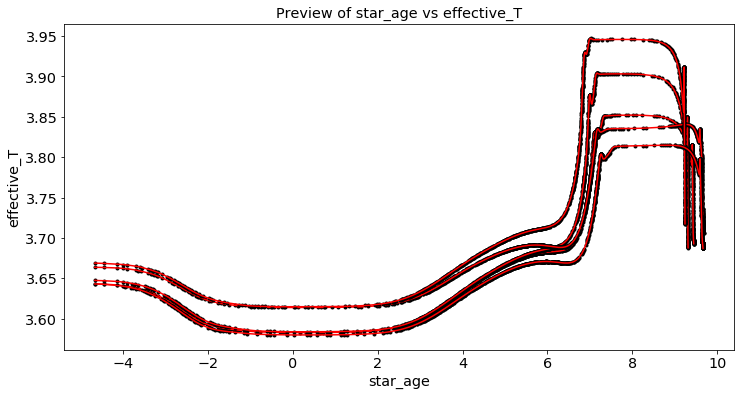

In [61]:
gk.preview_1d_data(condition = 'm1*_feh*_MLT1.9_fov0.018.csv', number = 5,
                   x = 'star_age', y = 'effective_T', 
                   ynormalization = None,
                   xlog = True, ylog = True, 
                   savefig = True)

# Step2 make initial guess of the kernel

individual kernel names are: ['constant','linear','poly2','poly3', 'poly4', 'poly5', 'poly6','cosine','arccosine', 'exponential', 'periodic', 'se', 'rq', 'matern12', 'matern32', 'matern52','static','white']

kernel combanitions are also available. Three notes: 1) kernel names and math symbols MUST be seperated by spaces, e.g. 'constant + linear * poly2'; 2) combanitions with + - * / are surpported; 3) do not use parentheses or brackets. For the case like '(se + poly3) * linear', please use 'se * linear + ploy3 * linear'

Examples:

kernels =  ['poly3', 'poly4', 'se', 'rq', 'matern12', 'matern32', 'matern52']

kernel_combanitions = ['constant + se', 'se + matern12', 'constant + poly3 + se', 'constant + poly3 + rq', 'linear * linear + se'] 

In [62]:
kernels = ['poly6', 'se', 'rq', 'matern12', 'matern32']
kernel_combanitions = ['constant + rq',
                       'constant + matern12',
                       'se + matern12',
                       'rq + matern12',
                       'poly4 + se', 
                       'poly4 + rq',
                       'poly4 + matern12',
                       'rq + matern32'
                      ]

We could also check kernel functions with following codes


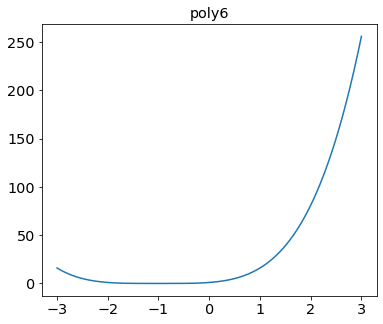

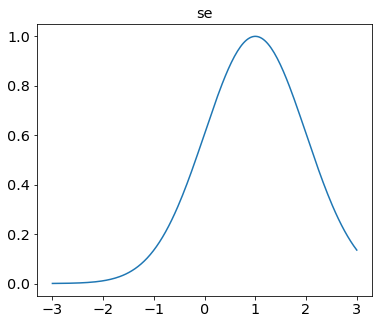

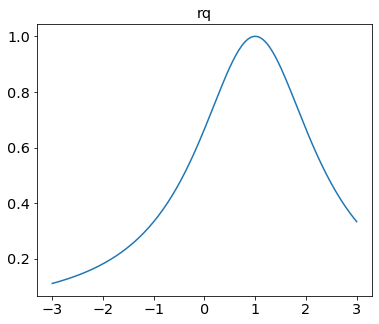

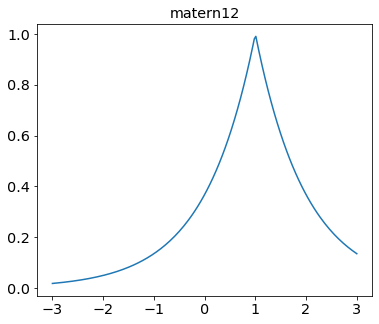

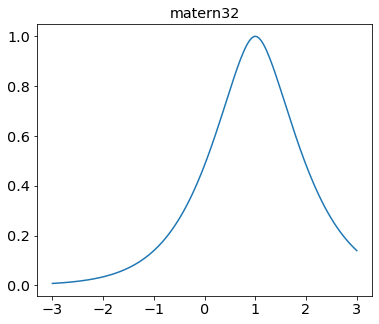

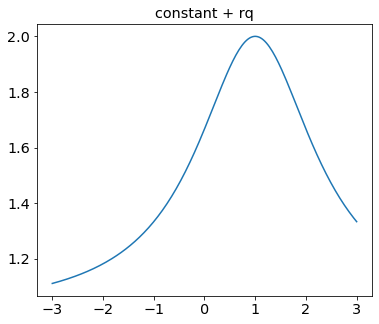

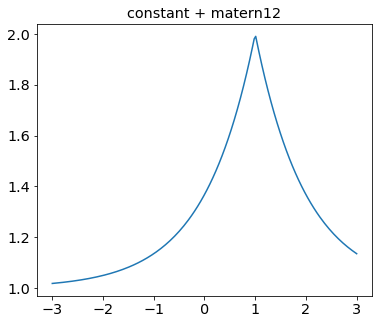

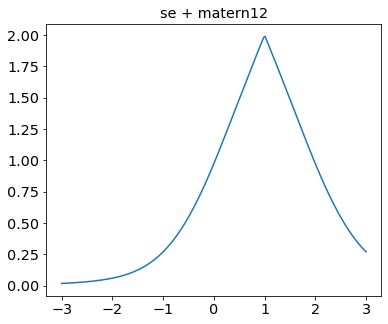

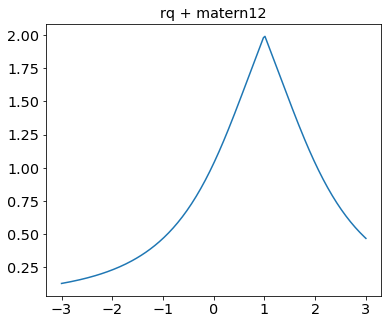

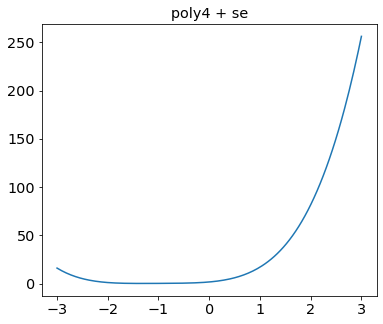

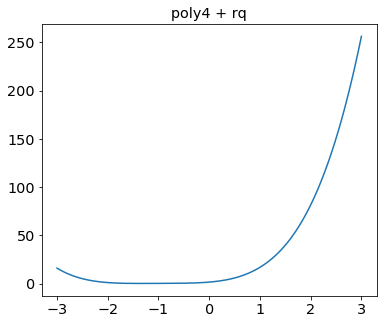

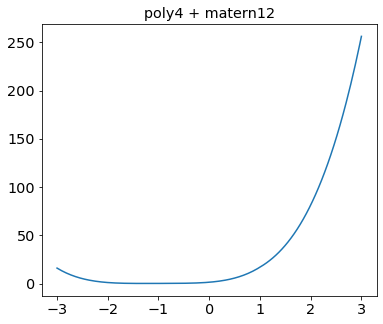

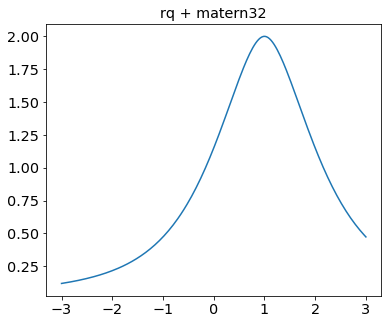

In [63]:
def plotkernelfunction(k = None, ax = None, xmin=None, xmax=None, other=None, kname = None):
    xx = np.linspace(xmin, xmax, 200)[:,None]
    ax.plot(xx, k(xx, np.zeros((1,1)) + other))
    ax.set_title(kname)

for kname in kernels:
    kernel = gk.kernel_bank(kname)
    f, axes = plt.subplots(1, 1, figsize=(6, 5), sharex=True)
    plotkernelfunction(k = kernel, ax = axes, xmin=-3, xmax=3, other=1.0, kname = kname)
    
for kname in kernel_combanitions:
    kernel = gk.solve_kernel_combanitions(kname)
    f, axes = plt.subplots(1, 1, figsize=(6, 5), sharex=True)
    plotkernelfunction(k = kernel, ax = axes, xmin=-3, xmax=3, other=1.0, kname = kname)

# Step 3 use a subset to test kernels

Initial guesses of kernels are:
[['poly6', 'se', 'rq', 'matern12', 'matern32'], ['constant + rq', 'constant + matern12', 'se + matern12', 'rq + matern12', 'poly4 + se', 'poly4 + rq', 'poly4 + matern12', 'rq + matern32']]
8/41tracks are used.
working on kernel: poly6(1/5)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:298: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


working on kernel: se(2/5)
working on kernel: rq(3/5)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:300: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:301: RuntimeWarning: invalid value encountered in sqrt


working on kernel: matern12(4/5)
working on kernel: matern32(5/5)
working on kernel combanitions: constant + rq(1/8)


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


working on kernel combanitions: constant + matern12(2/8)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:338: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:338: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:340: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:341: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:338: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/opt/anaco

working on kernel combanitions: se + matern12(3/8)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:340: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:341: RuntimeWarning: invalid value encountered in sqrt


working on kernel combanitions: rq + matern12(4/8)
working on kernel combanitions: poly4 + se(5/8)
working on kernel combanitions: poly4 + rq(6/8)
working on kernel combanitions: poly4 + matern12(7/8)
working on kernel combanitions: rq + matern32(8/8)
--- 1593.471391916275 seconds ---


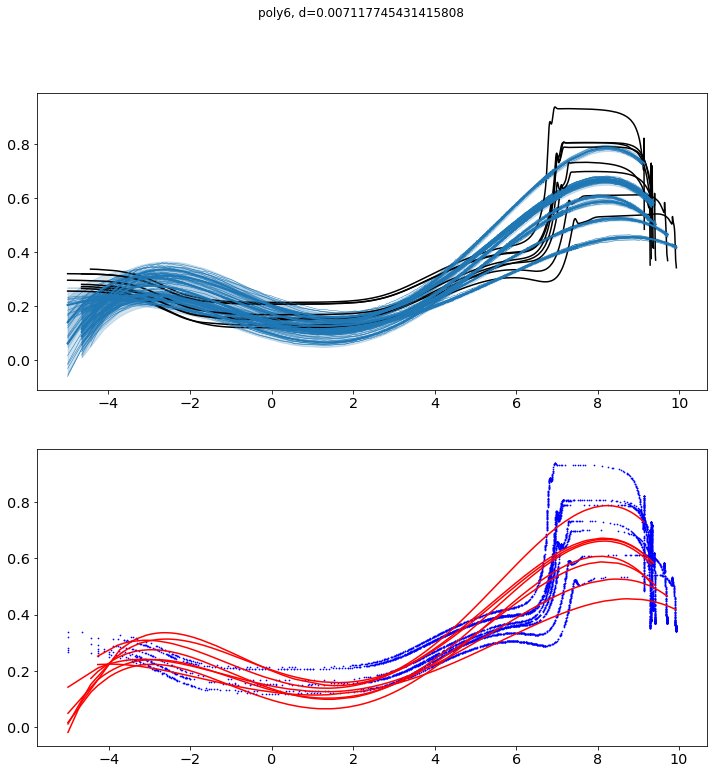

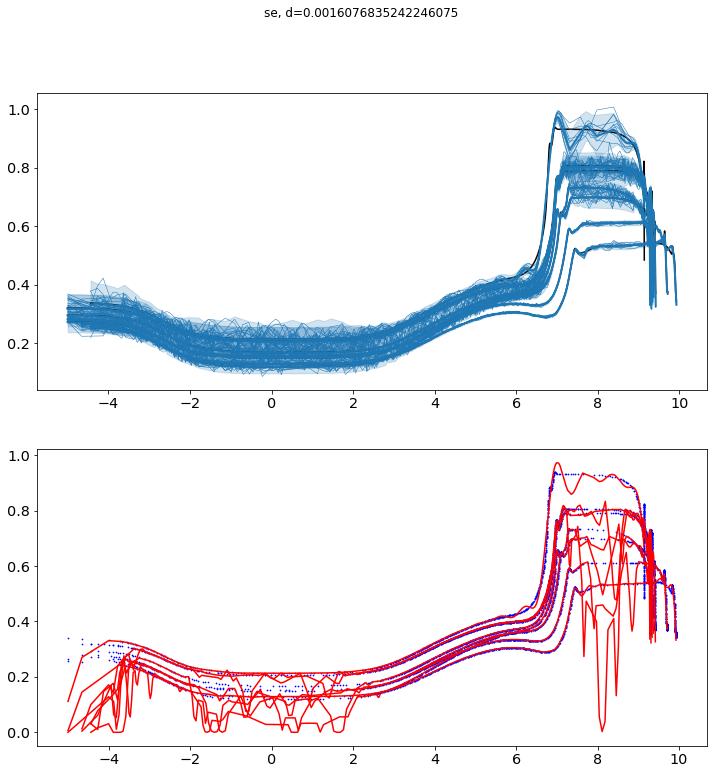

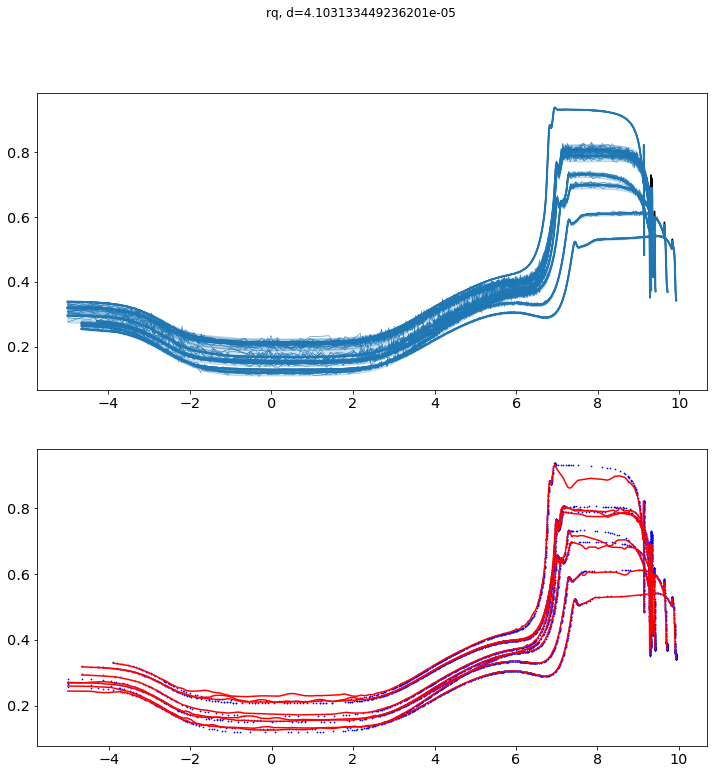

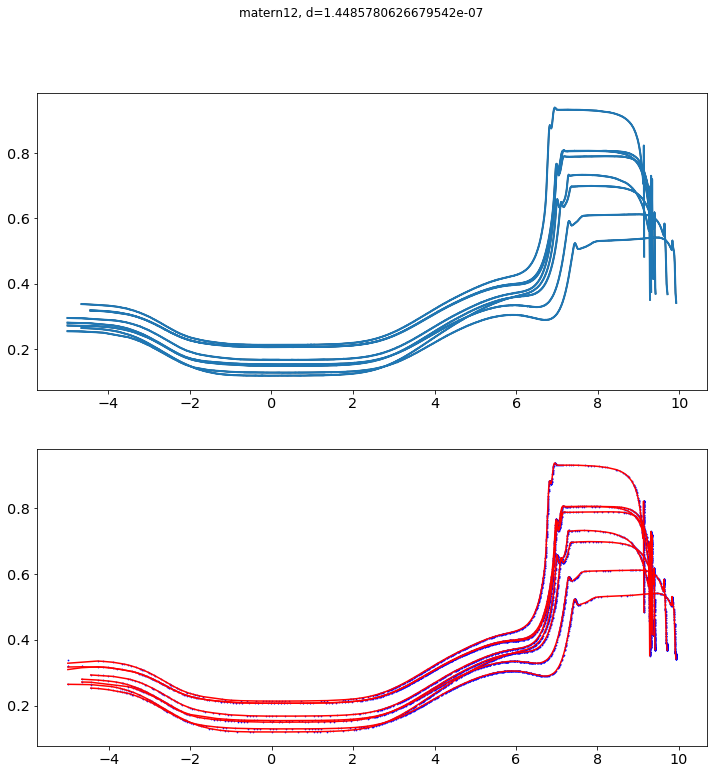

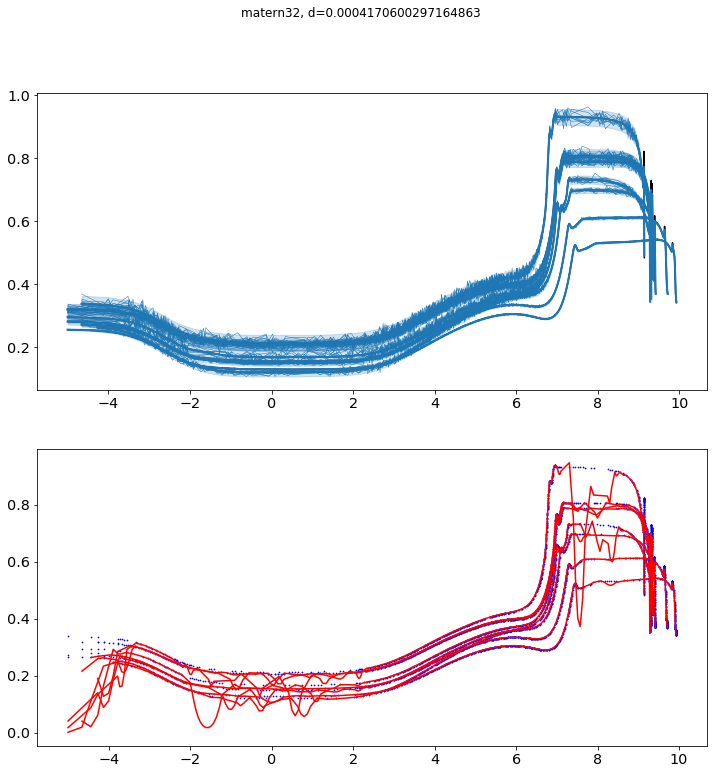

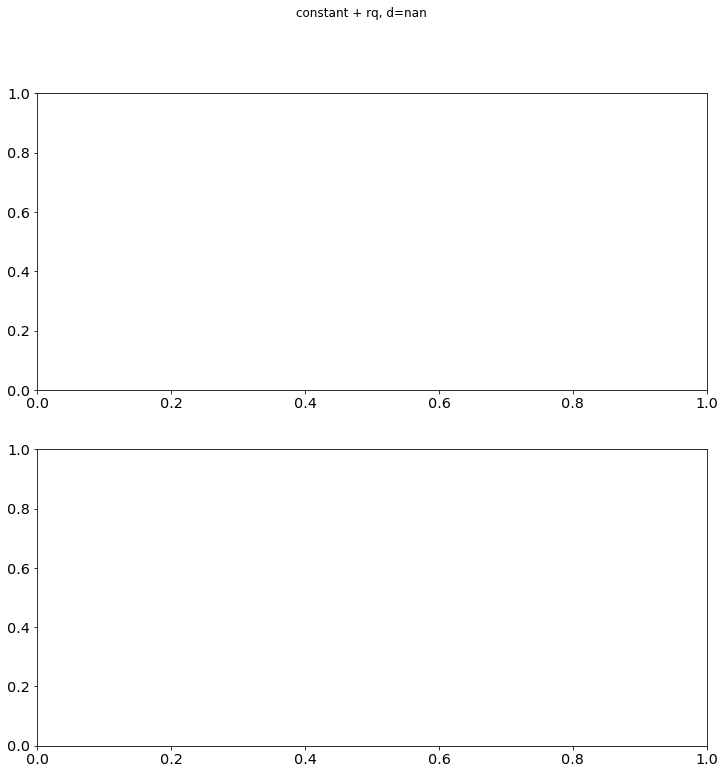

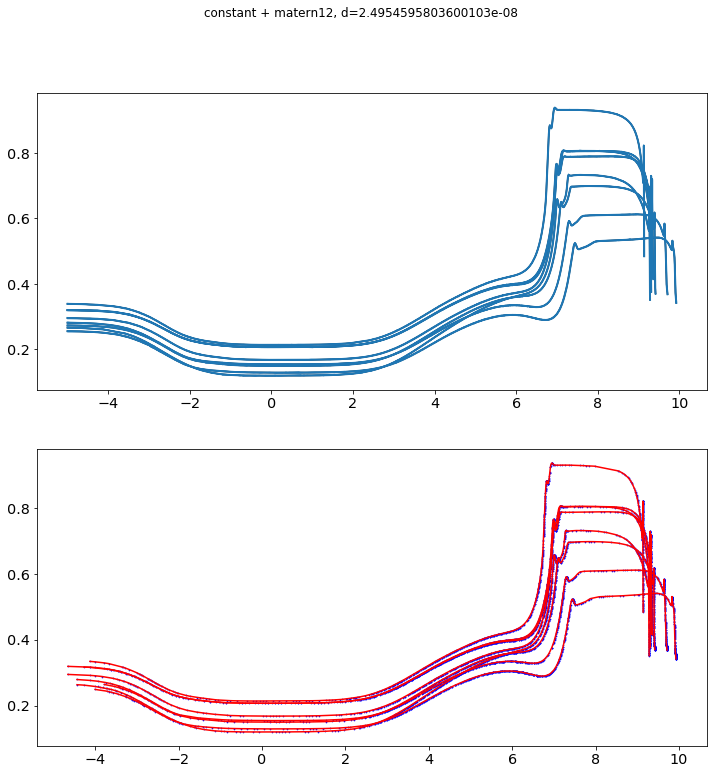

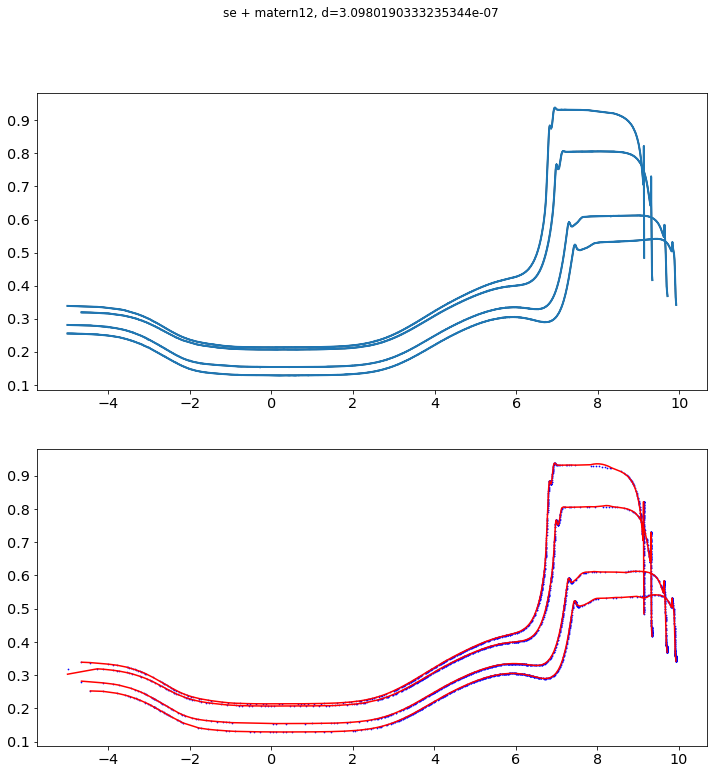

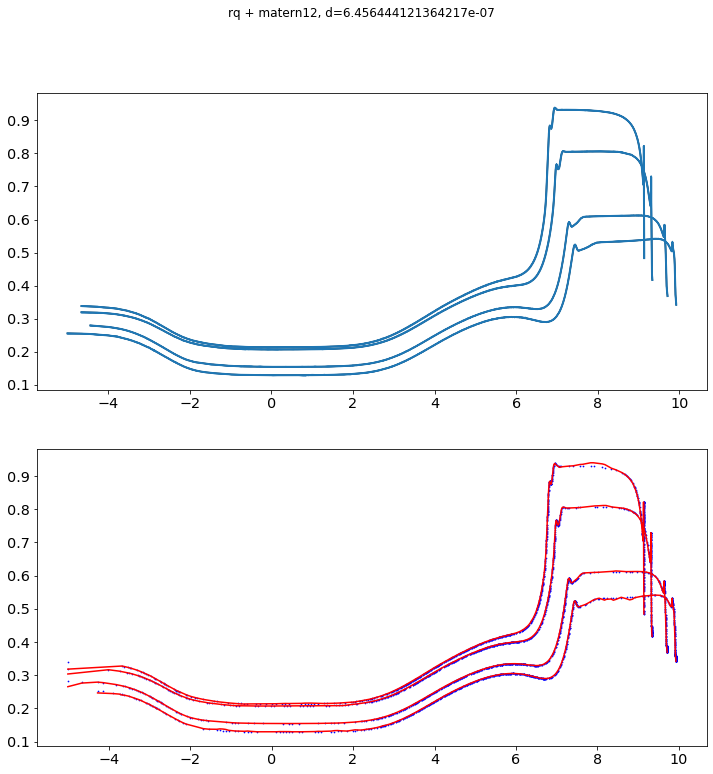

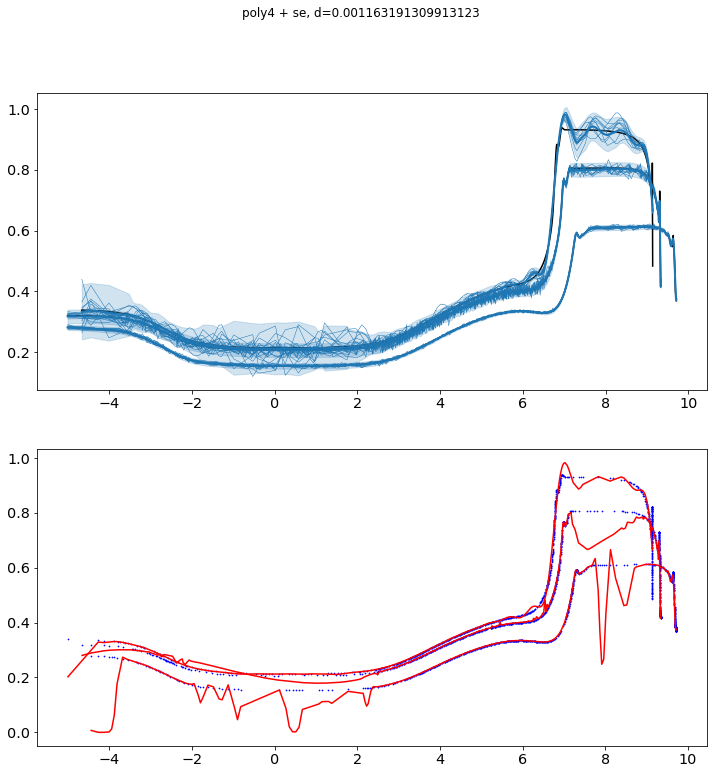

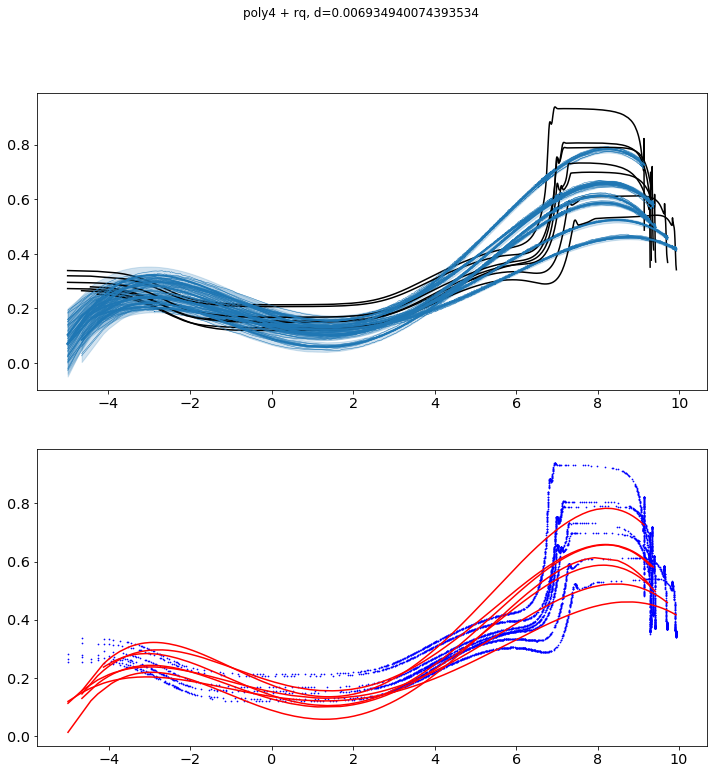

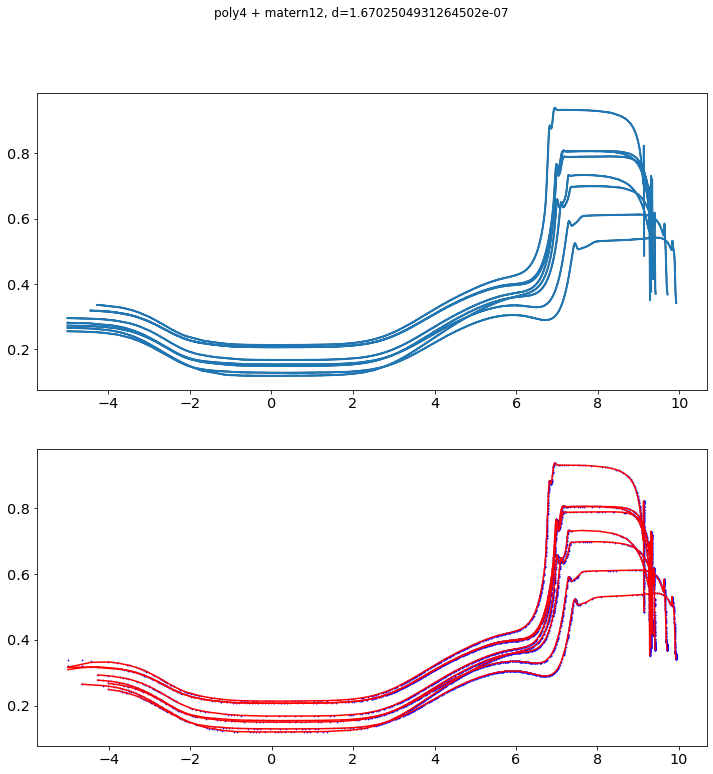

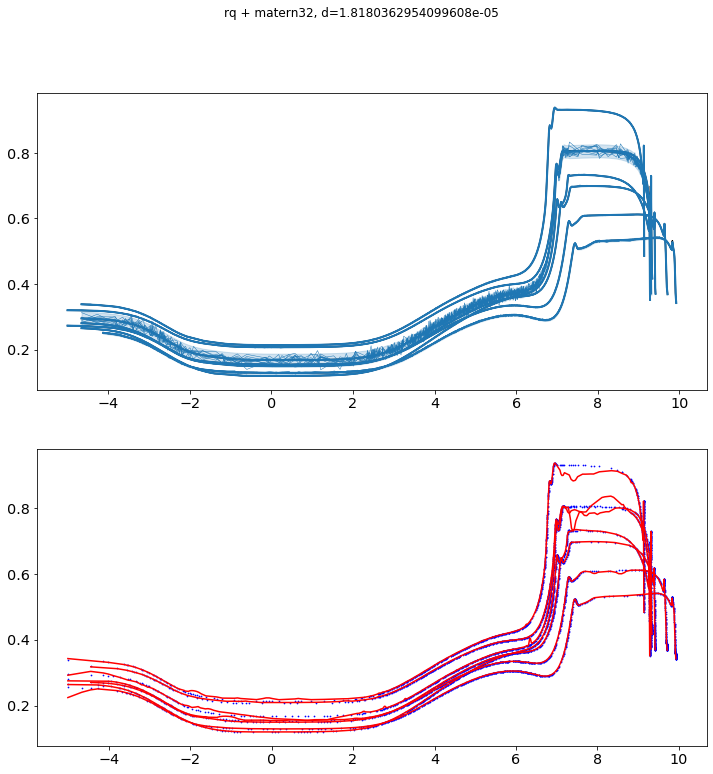

In [64]:
start_time = time.time()

teff_offset = gk.find_1d_kernel(condition = 'm1.*_feh*_MLT1.9_fov0.018.csv',
                                subset_fraction = 0.2, 
                                x = 'star_age', y = 'effective_T', 
                                xlog = True, ylog = True,
                                ynormalization = [3.5,4.0],
                                kernels = kernels, 
                                kernel_combanitions = kernel_combanitions,
                                iterations = 10,
                                printinfo = False, figures = True)

print("--- %s seconds ---" % (time.time() - start_time))

In [65]:
teff_offset

,poly6,se,rq,matern12,matern32,constant + rq,constant + matern12,se + matern12,rq + matern12,poly4 + se,poly4 + rq,poly4 + matern12,rq + matern32
0,0.008411,0.000920,0.000076,8.606151e-07,0.000224,-9999.0,1.271750e-08,4.500769e-07,4.987421e-07,0.000259,-9999.000000,2.044161e-07,6.863165e-06
1,0.011602,0.002265,0.000055,1.296443e-07,0.001887,-9999.0,6.164352e-08,3.810673e-07,1.172590e-06,0.002078,0.011669,8.699668e-07,1.991516e-05
2,0.004314,0.000960,0.000007,1.682608e-08,0.000006,-9999.0,1.486812e-08,5.735870e-08,3.531959e-07,0.001152,0.004456,1.457125e-08,1.450439e-06
3,0.003224,0.000132,0.000003,3.369083e-08,0.000004,-9999.0,6.133099e-09,3.507047e-07,5.580497e-07,-9999.000000,0.003056,5.544312e-09,1.861233e-06
4,0.006115,0.000909,0.000024,2.124637e-08,0.000305,-9999.0,2.458962e-08,-9.999000e+03,-9.999000e+03,-9999.000000,0.005873,2.351973e-08,7.976661e-07
5,0.005883,0.000475,0.000020,2.141745e-08,0.000207,-9999.0,5.913230e-09,-9.999000e+03,-9.999000e+03,-9999.000000,0.005665,1.547957e-08,1.820232e-07
6,0.007830,0.001276,0.000059,4.033056e-08,0.000111,-9999.0,1.156945e-08,-9.999000e+03,-9.999000e+03,-9999.000000,0.008085,1.858391e-07,-9.999000e+03
7,0.009563,0.005924,0.000083,3.509180e-08,0.000592,-9999.0,6.220223e-08,-9.999000e+03,-9.999000e+03,-9999.000000,0.009741,1.686357e-08,9.619286e-05
